In [1]:
nama = 'Tria Agusti Khoirun Nisa'
email = 'nisaagustin6@gmail.com'
alamat = 'Watesprojo, Kemlagi, Mojokerto'
proyek = 'Image Classification Model Deployment'

print(nama, email, alamat, proyek)

Tria Agusti Khoirun Nisa nisaagustin6@gmail.com Watesprojo, Kemlagi, Mojokerto Image Classification Model Deployment


Menghubungkan dataset yang ada di Google Drive dengan Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mengimpor library yang dibutuhkan dalam proyek

In [3]:
import tensorflow as tf
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Membuat nama untuk directory yang ada di dataset dalam Google Drive dan melihat kelasnya 

In [4]:
base_dir = '/content/drive/MyDrive/satelit'
os.listdir(base_dir)

['green_area', 'water', 'cloudy', 'desert']

Proses Augmentasi Dataset dibagi menjadi 80% train set dan 20% test set.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='wrap',
    validation_split=0.2)

Menyiapkan data latih dan data validasi dari kumpulan data gambar yang di-load dalam memori melalui fungsi flow()

In [6]:
train_generator = train_datagen.flow_from_directory(
    base_dir, 
    target_size=(100,150),
    shuffle=True,
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(100,150),
    subset='validation')

Found 3721 images belonging to 4 classes.
Found 929 images belonging to 4 classes.


Pembuatan CNN (Convolutional Neural Network). Proses klasifikasi gambar hanya berfokus pada atribut-atribut unik yang membedakan tiap kategori.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 148, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 17, 64)       0

Melakukan compile model menggunakan fungsi compile()

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Menggunakan Callback

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
      
callbacks = myCallback()

Pembuatan model yaitu model fitting. Proses ini memasukkan data latih pada jaringan Neural Network yang telah dibuat sebelumnya.

In [13]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=25,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=4,
                    verbose=2)

Epoch 1/50
25/25 - 7s - loss: 0.2739 - accuracy: 0.8913 - val_loss: 0.2329 - val_accuracy: 0.8672 - 7s/epoch - 268ms/step
Epoch 2/50
25/25 - 6s - loss: 0.2624 - accuracy: 0.9062 - val_loss: 0.2618 - val_accuracy: 0.9062 - 6s/epoch - 224ms/step
Epoch 3/50
25/25 - 6s - loss: 0.2357 - accuracy: 0.9075 - val_loss: 0.2437 - val_accuracy: 0.8906 - 6s/epoch - 230ms/step
Epoch 4/50
25/25 - 6s - loss: 0.2302 - accuracy: 0.9175 - val_loss: 0.1493 - val_accuracy: 0.9531 - 6s/epoch - 229ms/step
Epoch 5/50
25/25 - 6s - loss: 0.2251 - accuracy: 0.9175 - val_loss: 0.2241 - val_accuracy: 0.9141 - 6s/epoch - 228ms/step
Epoch 6/50
25/25 - 6s - loss: 0.2803 - accuracy: 0.8938 - val_loss: 0.2528 - val_accuracy: 0.8828 - 6s/epoch - 232ms/step
Epoch 7/50
25/25 - 6s - loss: 0.2529 - accuracy: 0.9035 - val_loss: 0.2762 - val_accuracy: 0.8906 - 6s/epoch - 230ms/step
Epoch 8/50
25/25 - 6s - loss: 0.2700 - accuracy: 0.8950 - val_loss: 0.2265 - val_accuracy: 0.8828 - 6s/epoch - 226ms/step
Epoch 9/50
25/25 - 6s - 

 Membuat plot terhadap akurasi dan loss model

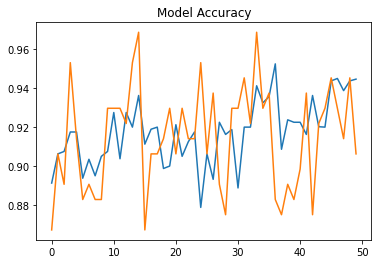

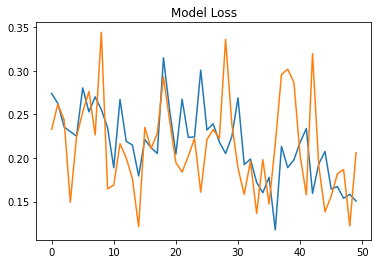

In [14]:
#plot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')

plt.show()

#plot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')

plt.show()

Menulis kode untuk menyimpan model ke dalam format TF-Lite

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)